## 根据纽约出租车的运营数据，针对客户旅途时间展开分析与建模。

In [1]:
import os
import pandas as pd
import numpy as np
from matplotlib.pyplot import *
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib import cm
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from dateutil import parser
import io
import base64

In [2]:
df = pd.read_csv('train.csv')
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


太远地方的就先去掉啦

In [3]:
xlim = [-74.03, -73.77]
ylim = [40.63, 40.85]
df = df[(df.pickup_longitude> xlim[0]) & (df.pickup_longitude < xlim[1])]
df = df[(df.dropoff_longitude> xlim[0]) & (df.dropoff_longitude < xlim[1])]
df = df[(df.pickup_latitude> ylim[0]) & (df.pickup_latitude < ylim[1])]
df = df[(df.dropoff_latitude> ylim[0]) & (df.dropoff_latitude < ylim[1])]

上下车地点集中区域

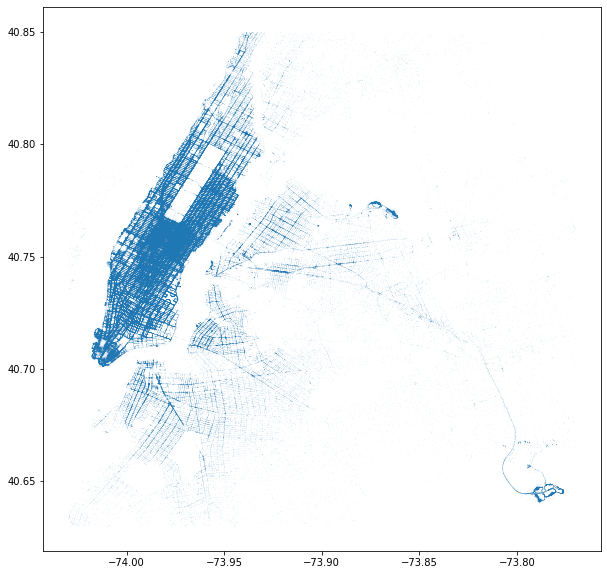

In [4]:
longitude = list(df.pickup_longitude) + list(df.dropoff_longitude)
latitude = list(df.pickup_latitude) + list(df.dropoff_latitude)
plt.figure(figsize = (10,10))
plt.plot(longitude,latitude,'.', alpha = 0.4, markersize = 0.05)
plt.show()

根据上下车的地点，将区域分一下，用聚类来试试

In [5]:
loc_df = pd.DataFrame()
loc_df['longitude'] = longitude
loc_df['latitude'] = latitude

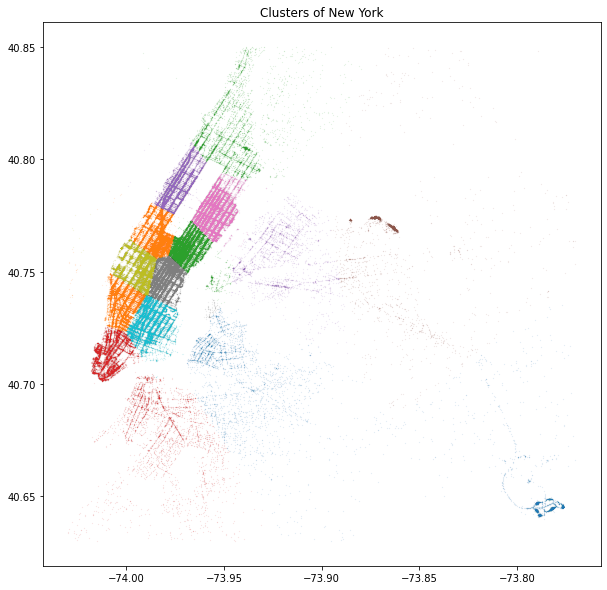

In [6]:
kmeans = KMeans(n_clusters=15, random_state=2, n_init = 10).fit(loc_df)
loc_df['label'] = kmeans.labels_

loc_df = loc_df.sample(200000)
plt.figure(figsize = (10,10))
for label in loc_df.label.unique():
    plt.plot(loc_df.longitude[loc_df.label == label],loc_df.latitude[loc_df.label == label],'.', alpha = 0.3, markersize = 0.3)

plt.title('Clusters of New York')
plt.show()

给区域来个标记吧

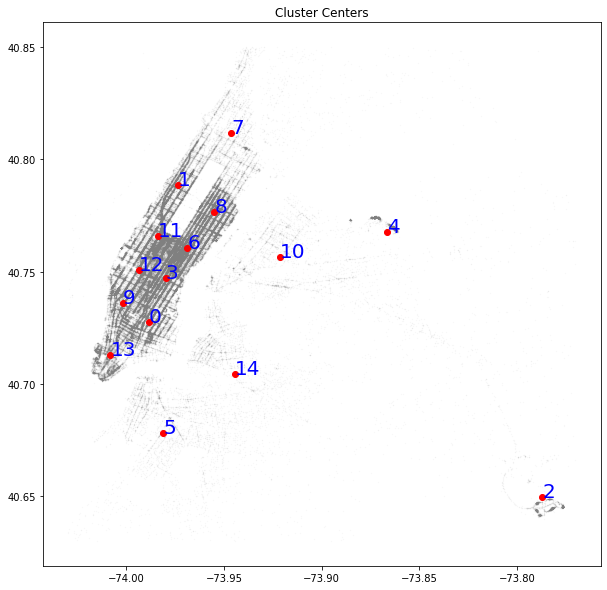

In [7]:
fig,ax = plt.subplots(figsize = (10,10))
for label in loc_df.label.unique():
    ax.plot(loc_df.longitude[loc_df.label == label],loc_df.latitude[loc_df.label == label],'.', alpha = 0.4, markersize = 0.1, color = 'gray')
    ax.plot(kmeans.cluster_centers_[label,0],kmeans.cluster_centers_[label,1],'o', color = 'r')
    ax.annotate(label, (kmeans.cluster_centers_[label,0],kmeans.cluster_centers_[label,1]), color = 'b', fontsize = 20)
ax.set_title('Cluster Centers')
plt.show()

In [8]:
df['pickup_cluster'] = kmeans.predict(df[['pickup_longitude','pickup_latitude']])
df['dropoff_cluster'] = kmeans.predict(df[['dropoff_longitude','dropoff_latitude']])
df['pickup_hour'] = df.pickup_datetime.apply(lambda x: parser.parse(x).hour )

/usr/local/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- pickup_latitude
- pickup_longitude
Feature names seen at fit time, yet now missing:
- latitude
- longitude

  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- dropoff_latitude
- dropoff_longitude
Feature names seen at fit time, yet now missing:
- latitude
- longitude

  warnings.warn(message, FutureWarning)


In [9]:
clusters = pd.DataFrame()
clusters['x'] = kmeans.cluster_centers_[:,0]
clusters['y'] = kmeans.cluster_centers_[:,1]
clusters['label'] = range(len(clusters))

loc_df = loc_df.sample(5000)

展示了方向与趋势，箭头的宽度与车流成正比

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (10,10))

def animate(hour):
    ax.clear()
    ax.set_title('Relative Traffic - Hour ' + str(int(hour)) + ':00')    
    plt.figure(figsize = (10,10))
    for label in loc_df.label.unique():
        ax.plot(loc_df.longitude[loc_df.label == label],loc_df.latitude[loc_df.label == label],'.', alpha = 1, markersize = 2, color = 'gray')
        ax.plot(kmeans.cluster_centers_[label,0],kmeans.cluster_centers_[label,1],'o', color = 'r')


    for label in clusters.label:
        for dest_label in clusters.label:
            num_of_rides = len(df[(df.pickup_cluster == label) & (df.dropoff_cluster == dest_label) & (df.pickup_hour == hour)])
            dist_x = clusters.x[clusters.label == label].values[0] - clusters.x[clusters.label == dest_label].values[0]
            dist_y = clusters.y[clusters.label == label].values[0] - clusters.y[clusters.label == dest_label].values[0]
            pct = np.true_divide(num_of_rides,len(df[df.pickup_hour == hour]))
            arr = Arrow(clusters.x[clusters.label == label].values, clusters.y[clusters.label == label].values, -dist_x, -dist_y, edgecolor='white', width = pct)
            ax.add_patch(arr)
            arr.set_facecolor('g')
    return [Artist()]


ani = animation.FuncAnimation(fig,animate,sorted(df.pickup_hour.unique()), interval = 1000)
plt.close()
ani.save('html/animation2.html', writer='imagemagick', fps=2)

/var/folders/86/7ptlxff10831w7wkzf15mypw0000gn/T/ipykernel_53319/2793729844.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize = (10,10))


邻居分析

In [ ]:
neighborhood = {-74.0019368351: 'Chelsea',-73.837549761: 'Queens',-73.7854240738: 'JFK',-73.9810421975:'Midtown-North-West',-73.9862336241: 'East Village',
                -73.971273324:'Midtown-North-East',-73.9866739677: 'Brooklyn-parkslope',-73.8690098118: 'LaGuardia',-73.9890572967:'Midtown',-74.0081765545: 'Downtown'
                ,-73.9213024854: 'Queens-Astoria',-73.9470256923: 'Harlem',-73.9555565018: 'Uppe East Side',
               -73.9453487097: 'Brooklyn-Williamsburgt',-73.9745967889:'Upper West Side'}

In [ ]:
rides_df = pd.DataFrame(columns = neighborhood.values())
rides_df['name'] = neighborhood.values()

neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(np.array(list(neighborhood.keys())).reshape(-1, 1), list(neighborhood.values()))

In [ ]:
df['pickup_neighborhood'] = neigh.predict(df.pickup_longitude.reshape(-1,1))
df['dropoff_neighborhood'] = neigh.predict(df.dropoff_longitude.reshape(-1,1))

for col in rides_df.columns[:-1]:
    rides_df[col] = rides_df.name.apply(lambda x: len(df[(df.pickup_neighborhood == x) & (df.dropoff_neighborhood == col)]))

In [ ]:
rides_df.head()

In [ ]:
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)

trace = go.Heatmap(z= np.array(rides_df.as_matrix()),
                  x = rides_df.columns[:-1],
                  y = rides_df.columns)
layout = dict(
    title = ' <b>Neighborhoods Interaction</b>',
    titlefont = dict(
    size = 30,
    color = ('rgb(100,100,100)')),
    margin = dict(t=100,r=100,b=100,l=150),
        yaxis = dict(
            title = ' <b> From </b>'),
        xaxis = dict(
            title = '<b> To </b>'))
data=[trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='labelled-heatmap')

进出分析

In [ ]:
fig,ax = plt.subplots(figsize = (12,12))
for i in range(len(rides_df)):  
    ax.plot(rides_df.sum(axis = 1)[i],rides_df.sum(axis = 0)[i],'o', color = 'b')
    ax.annotate(rides_df.index.tolist()[i], (rides_df.sum(axis = 1)[i],rides_df.sum(axis = 0)[i]), color = 'b', fontsize = 12)

ax.plot([0,250000],[0,250000], color = 'r', linewidth = 1)
ax.grid('off')
ax.set_xlim([0,250000])
ax.set_ylim([0,250000])
ax.set_xlabel('Outbound Taxis')
ax.set_ylabel('Inbound Taxis')
ax.set_title('Inbound and Outbound rides for each cluster')
plt.show()

我们可以看到，每个地区的出入的比率是相对平衡的。

In [ ]:
import pandas as pd  #pandas for using dataframe and reading csv 
import numpy as np   #numpy for vector operations and basic maths 
#import simplejson    #getting JSON in simplified format
import urllib        #for url stuff
#import gmaps       #for using google maps to visulalize places on maps
import re            #for processing regular expressions
import datetime      #for datetime operations
import calendar      #for calendar for datetime operations
import time          #to get the system time
import scipy         #for other dependancies
from sklearn.cluster import KMeans # for doing K-means clustering
from haversine import haversine # for calculating haversine distance
import math          #for basic maths operations
import seaborn as sns #for making plots
import matplotlib.pyplot as plt # for plotting
import os  # for os commands
from scipy.misc import imread, imresize, imsave  # for plots 
import plotly.plotly as py
import plotly.graph_objs as go
import plotly
from bokeh.palettes import Spectral4
from bokeh.plotting import figure, output_notebook, show
from IPython.display import HTML
from matplotlib.pyplot import *
from matplotlib import cm
from matplotlib import animation
import io
import base64
import warnings
warnings.filterwarnings("ignore")
output_notebook()
plotly.offline.init_notebook_mode() # run at the start of every ipython notebook

数据读取与特征选择

In [ ]:
s = time.time()
train_fr_1 = pd.read_csv('./data/fastest_routes_train_part_1.csv')
train_fr_2 = pd.read_csv('./data/fastest_routes_train_part_2.csv')
train_fr = pd.concat([train_fr_1, train_fr_2])
train_fr_new = train_fr[['id', 'total_distance', 'total_travel_time', 'number_of_steps']]
train_df = pd.read_csv('./data/train.csv')
train = pd.merge(train_df, train_fr_new, on = 'id', how = 'left')
train_df = train.copy()
end = time.time()
print("Time taken by above cell is {}.".format((end-s)))
train_df.head()

数据检查

In [ ]:
# checking if Ids are unique, 
train_data = train_df.copy()
print("Number of columns and rows and columns are {} and {} respectively.".format(train_data.shape[1], train_data.shape[0]))
if train_data.id.nunique() == train_data.shape[0]:
    print("Train ids are unique")
print("Number of Nulls - {}.".format(train_data.isnull().sum().sum()))

旅行持续时间log展示

In [ ]:
%matplotlib inline
start = time.time()
sns.set(style="white", palette="muted", color_codes=True)
f, axes = plt.subplots(1, 1, figsize=(11, 7), sharex=True)
sns.despine(left=True)
sns.distplot(np.log(train_df['trip_duration'].values+1), axlabel = 'Log(trip_duration)', label = 'log(trip_duration)', bins = 50, color="r")
plt.setp(axes, yticks=[])
plt.tight_layout()
end = time.time()
print("Time taken by above cell is {}.".format((end-start)))
plt.show()

正太分布的，有个别时间有点高的离谱了。。。有个别的神速了

In [ ]:
print ('大部分的旅行时间是在：',np.exp(4)/60,np.exp(8)/60)
print ('比较吊的。。。',np.exp(2)/60,np.exp(12)/60)

数据提供的位置

In [ ]:
start = time.time()
sns.set(style="white", palette="muted", color_codes=True)
f, axes = plt.subplots(2,2,figsize=(10, 10), sharex=False, sharey = False)
sns.despine(left=True)
sns.distplot(train_df['pickup_latitude'].values, label = 'pickup_latitude',color="m",bins = 100, ax=axes[0,0])
sns.distplot(train_df['pickup_longitude'].values, label = 'pickup_longitude',color="m",bins =100, ax=axes[0,1])
sns.distplot(train_df['dropoff_latitude'].values, label = 'dropoff_latitude',color="m",bins =100, ax=axes[1, 0])
sns.distplot(train_df['dropoff_longitude'].values, label = 'dropoff_longitude',color="m",bins =100, ax=axes[1, 1])
plt.setp(axes, yticks=[])
plt.tight_layout()
end = time.time()
print("Time taken by above cell is {}.".format((end-start)))
plt.show()

有些位置是不是太偏僻了，还是统计误差啊，去掉那些离谱的

纬度控制在40.6到40.9
经度控制在-74.05到-73.70

In [ ]:
start = time.time()
df = train_df.loc[(train_df.pickup_latitude > 40.6) & (train_df.pickup_latitude < 40.9)]
df = df.loc[(df.dropoff_latitude>40.6) & (df.dropoff_latitude < 40.9)]
df = df.loc[(df.dropoff_longitude > -74.05) & (df.dropoff_longitude < -73.7)]
df = df.loc[(df.pickup_longitude > -74.05) & (df.pickup_longitude < -73.7)]
train_data_new = df.copy()
sns.set(style="white", palette="muted", color_codes=True)
f, axes = plt.subplots(2,2,figsize=(12, 12), sharex=False, sharey = False)#
sns.despine(left=True)
sns.distplot(train_data_new['pickup_latitude'].values, label = 'pickup_latitude',color="m",bins = 100, ax=axes[0,0])
sns.distplot(train_data_new['pickup_longitude'].values, label = 'pickup_longitude',color="g",bins =100, ax=axes[0,1])
sns.distplot(train_data_new['dropoff_latitude'].values, label = 'dropoff_latitude',color="m",bins =100, ax=axes[1, 0])
sns.distplot(train_data_new['dropoff_longitude'].values, label = 'dropoff_longitude',color="g",bins =100, ax=axes[1, 1])
plt.setp(axes, yticks=[])
plt.tight_layout()
end = time.time()
print("Time taken by above cell is {}.".format((end-start)))
print(df.shape[0], train_data.shape[0])
plt.show()

以黑色为背景

In [ ]:
temp = train_data.copy()
start = time.time()
rgb = np.zeros((3000, 3500, 3), dtype=np.uint8)
rgb[..., 0] = 0
rgb[..., 1] = 0
rgb[..., 2] = 0
train_data_new['pick_lat_new'] = list(map(int, (train_data_new['pickup_latitude'] - (40.6000))*10000))
train_data_new['drop_lat_new'] = list(map(int, (train_data_new['dropoff_latitude'] - (40.6000))*10000))
train_data_new['pick_lon_new'] = list(map(int, (train_data_new['pickup_longitude'] - (-74.050))*10000))
train_data_new['drop_lon_new'] = list(map(int,(train_data_new['dropoff_longitude'] - (-74.050))*10000))

train_data_new.head()

In [ ]:
summary_plot = pd.DataFrame(train_data_new.groupby(['pick_lat_new', 'pick_lon_new'])['id'].count())

summary_plot.reset_index(inplace = True)
summary_plot.head()

In [ ]:
lat_list = summary_plot['pick_lat_new'].unique()
for i in lat_list:
    lon_list = summary_plot.loc[summary_plot['pick_lat_new']==i]['pick_lon_new'].tolist()
    unit = summary_plot.loc[summary_plot['pick_lat_new']==i]['id'].tolist()
    for j in lon_list:
        a = unit[lon_list.index(j)]
        if (a//50) >0:
            rgb[i][j][0] = 255
            rgb[i,j, 1] = 0
            rgb[i,j, 2] = 255
        elif (a//10)>0:
            rgb[i,j, 0] = 0
            rgb[i,j, 1] = 255
            rgb[i,j, 2] = 0
        else:
            rgb[i,j, 0] = 255
            rgb[i,j, 1] = 0
            rgb[i,j, 2] = 0
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(14,20))
end = time.time()
print("Time taken by above cell is {}.".format((end-start)))
ax.imshow(rgb, cmap = 'hot')
ax.set_axis_off() 

- 红点表示在给定数据中的1-10次行程具有该点作为起始点
- 绿点表示在给定数据中超过10-50次旅行具有该点作为起始点
- 黄点表示在给定数据中超过50次以上的行程具有该点作为起始点

特征工程：
选择对旅途时间有影响的因素

In [ ]:
#空间地理距离
start = time.time()
def haversine_(lat1, lng1, lat2, lng2):
    """function to calculate haversine distance between two co-ordinates"""
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return(h)

def manhattan_distance_pd(lat1, lng1, lat2, lng2):
    """function to calculate manhatten distance between pick_drop"""
    a = haversine_(lat1, lng1, lat1, lng2)
    b = haversine_(lat1, lng1, lat2, lng1)
    return a + b

import math
def bearing_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

end = time.time()
print("Time taken by above cell is {}.".format((end-start)))

In [ ]:
start = time.time()
train_data = temp.copy()
train_data['pickup_datetime'] = pd.to_datetime(train_data.pickup_datetime)
train_data.loc[:, 'pick_month'] = train_data['pickup_datetime'].dt.month
train_data.loc[:, 'hour'] = train_data['pickup_datetime'].dt.hour
train_data.loc[:, 'week_of_year'] = train_data['pickup_datetime'].dt.weekofyear
train_data.loc[:, 'day_of_year'] = train_data['pickup_datetime'].dt.dayofyear
train_data.loc[:, 'day_of_week'] = train_data['pickup_datetime'].dt.dayofweek
train_data.loc[:,'hvsine_pick_drop'] = haversine_(train_data['pickup_latitude'].values, train_data['pickup_longitude'].values, train_data['dropoff_latitude'].values, train_data['dropoff_longitude'].values)
train_data.loc[:,'manhtn_pick_drop'] = manhattan_distance_pd(train_data['pickup_latitude'].values, train_data['pickup_longitude'].values, train_data['dropoff_latitude'].values, train_data['dropoff_longitude'].values)
train_data.loc[:,'bearing'] = bearing_array(train_data['pickup_latitude'].values, train_data['pickup_longitude'].values, train_data['dropoff_latitude'].values, train_data['dropoff_longitude'].values)

end = time.time()
print("Time taken by above cell is {}.".format(end-start))


In [ ]:
start = time.time()
def color(hour):
    """function for color change in animation"""
    return(10*hour)

def Animation(hour, temp, rgb):
    """Function to generate return a pic of plotings"""
    #ax.clear()
    train_data_new = temp.loc[temp['hour'] == hour]
    start = time.time()
    rgb = np.zeros((3000, 3500, 3), dtype=np.uint8)
    rgb[..., 0] = 0
    rgb[..., 1] = 0
    rgb[..., 2] = 0
    train_data_new['pick_lat_new'] = list(map(int, (train_data_new['pickup_latitude'] - (40.6000))*10000))
    train_data_new['drop_lat_new'] = list(map(int, (train_data_new['dropoff_latitude'] - (40.6000))*10000))
    train_data_new['pick_lon_new'] = list(map(int, (train_data_new['pickup_longitude'] - (-74.050))*10000))
    train_data_new['drop_lon_new'] = list(map(int,(train_data_new['dropoff_longitude'] - (-74.050))*10000))

    summary_plot = pd.DataFrame(train_data_new.groupby(['pick_lat_new', 'pick_lon_new'])['id'].count())

    summary_plot.reset_index(inplace = True)
    summary_plot.head(120)
    lat_list = summary_plot['pick_lat_new'].unique()
    for i in lat_list:
        #print(i)
        lon_list = summary_plot.loc[summary_plot['pick_lat_new']==i]['pick_lon_new'].tolist()
        unit = summary_plot.loc[summary_plot['pick_lat_new']==i]['id'].tolist()
        for j in lon_list:
            #j = int(j)
            a = unit[lon_list.index(j)]
            #print(a)
            if (a//50) >0:
                rgb[i][j][0] = 255 - color(hour)
                rgb[i,j, 1] = 255 - color(hour)
                rgb[i,j, 2] = 0 + color(hour)
            elif (a//10)>0:
                rgb[i,j, 0] = 0 + color(hour)
                rgb[i,j, 1] = 255 - color(hour)
                rgb[i,j, 2] = 0 + color(hour)
            else:
                rgb[i,j, 0] = 255 - color(hour)
                rgb[i,j, 1] = 0 + color(hour)
                rgb[i,j, 2] = 0 + color(hour)
    #fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(14,20))
    end = time.time()
    print("Time taken by above cell is {} for {}.".format((end-start), hour))
    return(rgb)
end = time.time()
print("Time taken by above cell is {}.".format(end -start))

In [ ]:
start = time.time()
images_list=[]
train_data_new['pickup_datetime'] = pd.to_datetime(train_data_new.pickup_datetime)
train_data_new.loc[:, 'hour'] = train_data_new['pickup_datetime'].dt.hour

for i in list(range(0, 24)):
    im = Animation(i, train_data_new, rgb.copy())
    images_list.append(im)
end = time.time()
print("Time taken by above cell is {}.".format(end -start))

In [ ]:
start = time.time()
def build_gif(imgs = images_list, show_gif=False, save_gif=True, title=''):
    """function to create a gif of heatmaps"""
    fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(10,10))
    ax.set_axis_off()
    hr_range = list(range(0,24))
    def show_im(pairs):
        ax.clear()
        ax.set_title('Absolute Traffic - Hour ' + str(int(pairs[0])) + ':00')
        ax.imshow(pairs[1])
        ax.set_axis_off()
        return [Artist()]
    pairs = list(zip(hr_range, imgs))
    #ims = map(lambda x: (ax.imshow(x), ax.set_title(title)), imgs)
    im_ani = animation.FuncAnimation(fig, show_im, pairs,interval=500, repeat_delay=0, blit=False)
    plt.cla()
    if save_gif:
        im_ani.save('html/animation.html', writer='imagemagick') #, writer='imagemagick'
    if show_gif:
        plt.show()
    return
end = time.time()
print("Time taken by above cell is {}".format(end-start))

In [ ]:
start = time.time()
build_gif()
end = time.time()
print(end-start)

特征解释

In [ ]:
start = time.time()
summary_wdays_avg_duration = pd.DataFrame(train_data.groupby(['vendor_id','day_of_week'])['trip_duration'].mean())
summary_wdays_avg_duration.reset_index(inplace = True)
summary_wdays_avg_duration['unit']=1
sns.set(style="white", palette="muted", color_codes=True)
sns.set_context("poster")
sns.tsplot(data=summary_wdays_avg_duration, time="day_of_week", unit = "unit", condition="vendor_id", value="trip_duration")
sns.despine(bottom = False)
end = time.time()
print(end - start)

显而易见的是，出租车1类在一周中的所有日子里花费的时间都多于出租车2类，平均差不多多了250秒

vovin plot

In [ ]:
import seaborn as sns
sns.set(style="whitegrid", palette="pastel", color_codes=True)
sns.set_context("poster")
train_data2 = train_data.copy()
train_data2['trip_duration']= np.log(train_data['trip_duration'])
sns.violinplot(x="passenger_count", y="trip_duration", hue="vendor_id", data=train_data2, split=True,
               inner="quart",palette={1: "g", 2: "r"})

sns.despine(left=True)
print(df.shape[0])

- 空载是在刷单吗。。。
- 载客人数的分布情况差不多|

Box-Plots

In [ ]:
start = time.time()
sns.set(style="ticks")
sns.set_context("poster")
sns.boxplot(x="day_of_week", y="trip_duration", hue="vendor_id", data=train_data, palette="PRGn")
plt.ylim(0, 6000)
plt.legend(loc = 'upper right')
sns.despine(offset=10, trim=True)
print(train_data.trip_duration.max())
end = time.time()
print("Time taken by above cell is {}.".format(end-start))

- 周六日的出行时间更短一些

line-plots

In [ ]:
summary_hour_duration = pd.DataFrame(train_data.groupby(['day_of_week','hour'])['trip_duration'].mean())
summary_hour_duration.reset_index(inplace = True)
summary_hour_duration['unit']=1
sns.set(style="white", palette="muted", color_codes=False)
sns.set_context("poster")
sns.tsplot(data=summary_hour_duration, time="hour", unit = "unit", condition="day_of_week", value="trip_duration")
sns.despine(bottom = False)

- 周六日在5点到15点之间还是比较快的

聚类

In [ ]:
start = time.time()
def assign_cluster(df, k):
    """function to assign clusters """
    df_pick = df[['pickup_longitude','pickup_latitude']]
    df_drop = df[['dropoff_longitude','dropoff_latitude']]
    """I am using initialization as from the output of
    k-means from my local machine to save time in this kernel"""
    init = np.array([[ -73.98737616,   40.72981533],
       [-121.93328857,   37.38933945],
       [ -73.78423222,   40.64711269],
       [ -73.9546417 ,   40.77377538],
       [ -66.84140269,   36.64537175],
       [ -73.87040541,   40.77016484],
       [ -73.97316185,   40.75814346],
       [ -73.98861094,   40.7527791 ],
       [ -72.80966949,   51.88108444],
       [ -76.99779701,   38.47370625],
       [ -73.96975298,   40.69089596],
       [ -74.00816622,   40.71414939],
       [ -66.97216034,   44.37194443],
       [ -61.33552933,   37.85105133],
       [ -73.98001393,   40.7783577 ],
       [ -72.00626526,   43.20296402],
       [ -73.07618713,   35.03469086],
       [ -73.95759366,   40.80316361],
       [ -79.20167796,   41.04752096],
       [ -74.00106031,   40.73867723]])
    k_means_pick = KMeans(n_clusters=k, init=init, n_init=1)
    k_means_pick.fit(df_pick)
    clust_pick = k_means_pick.labels_
    df['label_pick'] = clust_pick.tolist()
    df['label_drop'] = k_means_pick.predict(df_drop)
    return df, k_means_pick

end = time.time()
print("time taken by thie script by now is {}.".format(end-start))

In [ ]:
start = time.time()
train_cl, k_means = assign_cluster(train_data, 20)  # make it 100 when extracting features 
centroid_pickups = pd.DataFrame(k_means.cluster_centers_, columns = ['centroid_pick_long', 'centroid_pick_lat'])
centroid_dropoff = pd.DataFrame(k_means.cluster_centers_, columns = ['centroid_drop_long', 'centroid_drop_lat'])
centroid_pickups['label_pick'] = centroid_pickups.index
centroid_dropoff['label_drop'] = centroid_dropoff.index
#centroid_pickups.head()
train_cl = pd.merge(train_cl, centroid_pickups, how='left', on=['label_pick'])
train_cl = pd.merge(train_cl, centroid_dropoff, how='left', on=['label_drop'])
#train_cl.head()
end = time.time()
print("Time taken in clustering is {}.".format(end - start))

聚类相关特征

- 上下客点所在簇中心点的距离
- 方向特征 - 集群质心之间的方向

In [ ]:
start = time.time()
train_cl.loc[:,'hvsine_pick_cent_p'] = haversine_(train_cl['pickup_latitude'].values, train_cl['pickup_longitude'].values, train_cl['centroid_pick_lat'].values, train_cl['centroid_pick_long'].values)
train_cl.loc[:,'hvsine_drop_cent_d'] = haversine_(train_cl['dropoff_latitude'].values, train_cl['dropoff_longitude'].values, train_cl['centroid_drop_lat'].values, train_cl['centroid_drop_long'].values)
train_cl.loc[:,'hvsine_cent_p_cent_d'] = haversine_(train_cl['centroid_pick_lat'].values, train_cl['centroid_pick_long'].values, train_cl['centroid_drop_lat'].values, train_cl['centroid_drop_long'].values)
train_cl.loc[:,'manhtn_pick_cent_p'] = manhattan_distance_pd(train_cl['pickup_latitude'].values, train_cl['pickup_longitude'].values, train_cl['centroid_pick_lat'].values, train_cl['centroid_pick_long'].values)
train_cl.loc[:,'manhtn_drop_cent_d'] = manhattan_distance_pd(train_cl['dropoff_latitude'].values, train_cl['dropoff_longitude'].values, train_cl['centroid_drop_lat'].values, train_cl['centroid_drop_long'].values)
train_cl.loc[:,'manhtn_cent_p_cent_d'] = manhattan_distance_pd(train_cl['centroid_pick_lat'].values, train_cl['centroid_pick_long'].values, train_cl['centroid_drop_lat'].values, train_cl['centroid_drop_long'].values)

train_cl.loc[:,'bearing_pick_cent_p'] = bearing_array(train_cl['pickup_latitude'].values, train_cl['pickup_longitude'].values, train_cl['centroid_pick_lat'].values, train_cl['centroid_pick_long'].values)
train_cl.loc[:,'bearing_drop_cent_p'] = bearing_array(train_cl['dropoff_latitude'].values, train_cl['dropoff_longitude'].values, train_cl['centroid_drop_lat'].values, train_cl['centroid_drop_long'].values)
train_cl.loc[:,'bearing_cent_p_cent_d'] = bearing_array(train_cl['centroid_pick_lat'].values, train_cl['centroid_pick_long'].values, train_cl['centroid_drop_lat'].values, train_cl['centroid_drop_long'].values)
train_cl['speed_hvsn'] = train_cl.hvsine_pick_drop/train_cl.total_travel_time
train_cl['speed_manhtn'] = train_cl.manhtn_pick_drop/train_cl.total_travel_time
end = time.time()
print("Time Taken by above cell is {}.".format(end-start))
train_cl.head()

聚类可视化展示

In [ ]:
start = time.time()
def cluster_summary(sum_df):
    """function to calculate summary of given list of clusters """
    #agg_func = {'trip_duration':'mean','label_drop':'count','bearing':'mean','id':'count'} # that's how you use agg function with groupby
    summary_avg_time = pd.DataFrame(sum_df.groupby('label_pick')['trip_duration'].mean())
    summary_avg_time.reset_index(inplace = True)
    summary_pref_clus = pd.DataFrame(sum_df.groupby(['label_pick', 'label_drop'])['id'].count())
    summary_pref_clus = summary_pref_clus.reset_index()
    summary_pref_clus = summary_pref_clus.loc[summary_pref_clus.groupby('label_pick')['id'].idxmax()]
    summary =pd.merge(summary_avg_time, summary_pref_clus, how = 'left', on = 'label_pick')
    summary = summary.rename(columns={'trip_duration':'avg_triptime'})
    return summary
end = time.time()
print("Time Taken by above cell is {}.".format(end-start))

In [ ]:
import folium
def show_fmaps(train_data, path=1):
    """function to generate map and add the pick up and drop coordinates
    1. Path = 1 : Join pickup (blue) and drop(red) using a straight line
    """
    full_data = train_data
    summary_full_data = pd.DataFrame(full_data.groupby('label_pick')['id'].count())
    summary_full_data.reset_index(inplace = True)
    summary_full_data = summary_full_data.loc[summary_full_data['id']>70000]
    map_1 = folium.Map(location=[40.767937, -73.982155], zoom_start=10,tiles='Stamen Toner') # manually added centre
    new_df = train_data.loc[train_data['label_pick'].isin(summary_full_data.label_pick.tolist())].sample(50)
    new_df.reset_index(inplace = True, drop = True)
    for i in range(new_df.shape[0]):
        pick_long = new_df.loc[new_df.index ==i]['pickup_longitude'].values[0]
        pick_lat = new_df.loc[new_df.index ==i]['pickup_latitude'].values[0]
        dest_long = new_df.loc[new_df.index ==i]['dropoff_longitude'].values[0]
        dest_lat = new_df.loc[new_df.index ==i]['dropoff_latitude'].values[0]
        folium.Marker([pick_lat, pick_long]).add_to(map_1)
        folium.Marker([dest_lat, dest_long]).add_to(map_1)
    return map_1

重点的clusters：大于70000个记录

In [ ]:
def clusters_map(clus_data, full_data, tile = 'OpenStreetMap', sig = 0, zoom = 12, circle = 0, radius_ = 30):
    """ function to plot clusters on map"""
    map_1 = folium.Map(location=[40.767937, -73.982155], zoom_start=zoom,tiles= tile) # 'Mapbox' 'Stamen Toner'
    summary_full_data = pd.DataFrame(full_data.groupby('label_pick')['id'].count())
    summary_full_data.reset_index(inplace = True)
    if sig == 1:
        summary_full_data = summary_full_data.loc[summary_full_data['id']>70000]
    sig_cluster = summary_full_data['label_pick'].tolist()
    clus_summary = cluster_summary(full_data)
    for i in sig_cluster:
        pick_long = clus_data.loc[clus_data.index ==i]['centroid_pick_long'].values[0]
        pick_lat = clus_data.loc[clus_data.index ==i]['centroid_pick_lat'].values[0]
        clus_no = clus_data.loc[clus_data.index ==i]['label_pick'].values[0]
        most_visited_clus = clus_summary.loc[clus_summary['label_pick']==i]['label_drop'].values[0]
        avg_triptime = clus_summary.loc[clus_summary['label_pick']==i]['avg_triptime'].values[0]
        pop = 'cluster = '+str(clus_no)+' & most visited cluster = ' +str(most_visited_clus) +' & avg triptime from this cluster =' + str(avg_triptime)
        if circle == 1:
            folium.CircleMarker(location=[pick_lat, pick_long], radius=radius_,
                    color='#F08080',
                    fill_color='#3186cc', popup=pop).add_to(map_1)
        folium.Marker([pick_lat, pick_long], popup=pop).add_to(map_1)
    return map_1

In [ ]:
osm = show_fmaps(train_data, path=1)
osm

In [ ]:
clus_map = clusters_map(centroid_pickups, train_cl, sig =0, zoom =3.2, circle =1, tile = 'Stamen Terrain')
clus_map

In [ ]:
clus_map_sig = clusters_map(centroid_pickups, train_cl, sig =1, circle =1)
clus_map_sig

测试集进行相同的处理

In [ ]:
test_df = pd.read_csv('./data/test.csv')
test_fr = pd.read_csv('./data/fastest_routes_test.csv')
test_fr_new = test_fr[['id', 'total_distance', 'total_travel_time', 'number_of_steps']]
test_df = pd.merge(test_df, test_fr_new, on = 'id', how = 'left')
test_df.head()

时间特征

In [ ]:
start = time.time()
test_data = test_df.copy()
test_data['pickup_datetime'] = pd.to_datetime(test_data.pickup_datetime)
test_data.loc[:, 'pick_month'] = test_data['pickup_datetime'].dt.month
test_data.loc[:, 'hour'] = test_data['pickup_datetime'].dt.hour
test_data.loc[:, 'week_of_year'] = test_data['pickup_datetime'].dt.weekofyear
test_data.loc[:, 'day_of_year'] = test_data['pickup_datetime'].dt.dayofyear
test_data.loc[:, 'day_of_week'] = test_data['pickup_datetime'].dt.dayofweek
end = time.time()
print("Time taken by above cell is {}.".format(end-start))

距离特征

In [ ]:
strat = time.time()
test_data.loc[:,'hvsine_pick_drop'] = haversine_(test_data['pickup_latitude'].values, test_data['pickup_longitude'].values, test_data['dropoff_latitude'].values, test_data['dropoff_longitude'].values)
test_data.loc[:,'manhtn_pick_drop'] = manhattan_distance_pd(test_data['pickup_latitude'].values, test_data['pickup_longitude'].values, test_data['dropoff_latitude'].values, test_data['dropoff_longitude'].values)
test_data.loc[:,'bearing'] = bearing_array(test_data['pickup_latitude'].values, test_data['pickup_longitude'].values, test_data['dropoff_latitude'].values, test_data['dropoff_longitude'].values)
end = time.time()
print("Time taken by above cell is {}.".format(end-strat))

聚类特征

In [ ]:
start = time.time()
test_data['label_pick'] = k_means.predict(test_data[['pickup_longitude','pickup_latitude']])
test_data['label_drop'] = k_means.predict(test_data[['dropoff_longitude','dropoff_latitude']])
test_cl = pd.merge(test_data, centroid_pickups, how='left', on=['label_pick'])
test_cl = pd.merge(test_cl, centroid_dropoff, how='left', on=['label_drop'])
#test_cl.head()
end = time.time()
print("Time Taken by above cell is {}.".format(end-start))

In [ ]:
start = time.time()
test_cl.loc[:,'hvsine_pick_cent_p'] = haversine_(test_cl['pickup_latitude'].values, test_cl['pickup_longitude'].values, test_cl['centroid_pick_lat'].values, test_cl['centroid_pick_long'].values)
test_cl.loc[:,'hvsine_drop_cent_d'] = haversine_(test_cl['dropoff_latitude'].values, test_cl['dropoff_longitude'].values, test_cl['centroid_drop_lat'].values, test_cl['centroid_drop_long'].values)
test_cl.loc[:,'hvsine_cent_p_cent_d'] = haversine_(test_cl['centroid_pick_lat'].values, test_cl['centroid_pick_long'].values, test_cl['centroid_drop_lat'].values, test_cl['centroid_drop_long'].values)
test_cl.loc[:,'manhtn_pick_cent_p'] = manhattan_distance_pd(test_cl['pickup_latitude'].values, test_cl['pickup_longitude'].values, test_cl['centroid_pick_lat'].values, test_cl['centroid_pick_long'].values)
test_cl.loc[:,'manhtn_drop_cent_d'] = manhattan_distance_pd(test_cl['dropoff_latitude'].values, test_cl['dropoff_longitude'].values, test_cl['centroid_drop_lat'].values, test_cl['centroid_drop_long'].values)
test_cl.loc[:,'manhtn_cent_p_cent_d'] = manhattan_distance_pd(test_cl['centroid_pick_lat'].values, test_cl['centroid_pick_long'].values, test_cl['centroid_drop_lat'].values, test_cl['centroid_drop_long'].values)

test_cl.loc[:,'bearing_pick_cent_p'] = bearing_array(test_cl['pickup_latitude'].values, test_cl['pickup_longitude'].values, test_cl['centroid_pick_lat'].values, test_cl['centroid_pick_long'].values)
test_cl.loc[:,'bearing_drop_cent_p'] = bearing_array(test_cl['dropoff_latitude'].values, test_cl['dropoff_longitude'].values, test_cl['centroid_drop_lat'].values, test_cl['centroid_drop_long'].values)
test_cl.loc[:,'bearing_cent_p_cent_d'] = bearing_array(test_cl['centroid_pick_lat'].values, test_cl['centroid_pick_long'].values, test_cl['centroid_drop_lat'].values, test_cl['centroid_drop_long'].values)
test_cl['speed_hvsn'] = test_cl.hvsine_pick_drop/test_cl.total_travel_time
test_cl['speed_manhtn'] = test_cl.manhtn_pick_drop/test_cl.total_travel_time
end = time.time()
print("Time Taken by above cell is {}.".format(end-start))

In [ ]:
test_cl.head()

xgboost模型

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
import warnings

可以尝试加入PCA特征

In [ ]:
# Lets Add PCA features in the model, reference Beluga's PCA
train = train_cl
test = test_cl
start = time.time()
coords = np.vstack((train[['pickup_latitude', 'pickup_longitude']].values,
                    train[['dropoff_latitude', 'dropoff_longitude']].values,
                    test[['pickup_latitude', 'pickup_longitude']].values,
                    test[['dropoff_latitude', 'dropoff_longitude']].values))

pca = PCA().fit(coords)
train['pickup_pca0'] = pca.transform(train[['pickup_latitude', 'pickup_longitude']])[:, 0]
train['pickup_pca1'] = pca.transform(train[['pickup_latitude', 'pickup_longitude']])[:, 1]
train['dropoff_pca0'] = pca.transform(train[['dropoff_latitude', 'dropoff_longitude']])[:, 0]
train['dropoff_pca1'] = pca.transform(train[['dropoff_latitude', 'dropoff_longitude']])[:, 1]
test['pickup_pca0'] = pca.transform(test[['pickup_latitude', 'pickup_longitude']])[:, 0]
test['pickup_pca1'] = pca.transform(test[['pickup_latitude', 'pickup_longitude']])[:, 1]
test['dropoff_pca0'] = pca.transform(test[['dropoff_latitude', 'dropoff_longitude']])[:, 0]
test['dropoff_pca1'] = pca.transform(test[['dropoff_latitude', 'dropoff_longitude']])[:, 1]
end = time.time()
print("Time Taken by above cell is {}.".format(end - start))

In [ ]:
train['store_and_fwd_flag_int'] = np.where(train['store_and_fwd_flag']=='N', 0, 1)
test['store_and_fwd_flag_int'] = np.where(test['store_and_fwd_flag']=='N', 0, 1)

In [ ]:
feature_names = list(train.columns)
print("Difference of features in train and test are {}".format(np.setdiff1d(train.columns, test.columns)))
print("")
do_not_use_for_training = ['pick_date','id', 'pickup_datetime', 'dropoff_datetime', 'trip_duration', 'store_and_fwd_flag']
feature_names = [f for f in train.columns if f not in do_not_use_for_training]
print("We will be using following features for training {}.".format(feature_names))
print("")
print("Total number of features are {}.".format(len(feature_names)))

In [ ]:
y = np.log(train['trip_duration'].values + 1)

In [ ]:
start = time.time()
Xtr, Xv, ytr, yv = train_test_split(train[feature_names].values, y, test_size=0.2, random_state=1987)
dtrain = xgb.DMatrix(Xtr, label=ytr)
dvalid = xgb.DMatrix(Xv, label=yv)
dtest = xgb.DMatrix(test[feature_names].values)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

xgb_pars = {'min_child_weight': 50, 'eta': 0.3, 'colsample_bytree': 0.3, 'max_depth': 10,
            'subsample': 0.8, 'lambda': 1., 'nthread': -1, 'booster' : 'gbtree', 'silent': 1,
            'eval_metric': 'rmse', 'objective': 'reg:linear'}

# You could try to train with more epoch
model = xgb.train(xgb_pars, dtrain, 15, watchlist, early_stopping_rounds=2,
                  maximize=False, verbose_eval=1)
end = time.time()
print("Time taken by above cell is {}.".format(end - start))
print('Modeling RMSLE %.5f' % model.best_score)

加入更多特征

天气特征

In [ ]:
weather = pd.read_csv('./data/weather_data_nyc_centralpark_2016.csv')
weather.head()

In [ ]:
from ggplot import *
weather.date = pd.to_datetime(weather.date)
weather['day_of_year']= weather.date.dt.dayofyear
p = ggplot(aes(x='date'),data=weather) + geom_line(aes(y='minimum temperature', colour = "blue")) + geom_line(aes(y='maximum temperature', colour = "red"))
p + geom_point(aes(y='minimum temperature',colour = "blue")) #+ stat_smooth(colour='yellow', span=0.2)

下雪，降雨，积雪情况

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
weather['precipitation'].unique()
weather['precipitation'] = np.where(weather['precipitation']=='T', '0.00',weather['precipitation'])
weather['precipitation'] = list(map(float, weather['precipitation']))
weather['snow fall'] = np.where(weather['snow fall']=='T', '0.00',weather['snow fall'])
weather['snow fall'] = list(map(float, weather['snow fall']))
weather['snow depth'] = np.where(weather['snow depth']=='T', '0.00',weather['snow depth'])
weather['snow depth'] = list(map(float, weather['snow depth']))

In [ ]:
import plotly.plotly as py
import plotly.graph_objs as go
import plotly
random_x = weather['date'].values
random_y0 = weather['precipitation']
random_y1 = weather['snow fall']
random_y2 = weather['snow depth']

import plotly.plotly as py
import plotly.graph_objs as go
import plotly
random_x = weather['date'].values
random_y0 = weather['precipitation']
random_y1 = weather['snow fall']
random_y2 = weather['snow depth']

# Create traces
trace0 = go.Scatter(
    x = random_x,
    y = random_y0,
    mode = 'markers',
    name = 'precipitation'
)
trace1 = go.Scatter(
    x = random_x,
    y = random_y1,
    mode = 'markers',
    name = 'snow fall'
)
trace2 = go.Scatter(
    x = random_x,
    y = random_y2,
    mode = 'markers',
    name = 'snow depth'
)

data = [trace0, trace1, trace2]
plotly.offline.iplot(data, filename='scatter-mode')


动作方向

In [ ]:
def freq_turn(step_dir):
    """function to create dummy for turn type"""
    from collections import Counter
    step_dir_new = step_dir.split("|")
    a_list = Counter(step_dir_new).most_common()
    path = {}
    for i in range(len(a_list)):
        path.update({a_list[i]})
    a = 0
    b = 0
    c = 0
    if 'straight' in (path.keys()):
        a = path['straight']
        #print(a)
    if 'left' in (path.keys()):
        b = path['left']
        #print(b)
    if 'right' in (path.keys()):
        c = path['right']
        #print(c)
    return a,b,c

In [ ]:
start = time.time()
train_fr['straight']= 0
train_fr['left'] =0
train_fr['right'] = 0
train_fr['straight'], train_fr['left'], train_fr['right'] = zip(*train_fr['step_direction'].map(freq_turn))
end = time.time()
print("Time Taken by above cell is {}.".format(end - start))

In [ ]:
train_fr_new = train_fr[['id','straight','left','right']]
train = pd.merge(train, train_fr_new, on = 'id', how = 'left')
#train = pd.merge(train, weather, on= 'date', how = 'left')
print(len(train.columns))
#train.columns

In [ ]:
train.head()

加入天气特征

In [ ]:
train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'])
train['date'] = train['pickup_datetime'].dt.date
train.head()

train['date'] = pd.to_datetime(train['date'])
train = pd.merge(train, weather[['date','minimum temperature', 'precipitation', 'snow fall', 'snow depth']], on= 'date', how = 'left')
train.shape[0]

In [ ]:
train.loc[:,'hvsine_pick_cent_d'] = haversine_(train['pickup_latitude'].values, train['pickup_longitude'].values, train['centroid_drop_lat'].values, train['centroid_drop_long'].values)
train.loc[:,'hvsine_drop_cent_p'] = haversine_(train['dropoff_latitude'].values, train['dropoff_longitude'].values, train['centroid_pick_lat'].values, train['centroid_pick_long'].values)

test.loc[:,'hvsine_pick_cent_d'] = haversine_(test['pickup_latitude'].values, test['pickup_longitude'].values, test['centroid_drop_lat'].values, test['centroid_drop_long'].values)
test.loc[:,'hvsine_drop_cent_p'] = haversine_(test['dropoff_latitude'].values, test['dropoff_longitude'].values, test['centroid_pick_lat'].values, test['centroid_pick_long'].values)

print("shape of train_features is {}.".format(len(train.columns)))

测试集才用相同的特征

In [ ]:
start = time.time()
test_fr['straight']= 0
test_fr['left'] =0
test_fr['right'] = 0
test_fr['straight'], test_fr['left'], test_fr['right'] = zip(*test_fr['step_direction'].map(freq_turn))
end = time.time()
print("Time Taken by above cell is {}.".format(end - start))
#test_fr.head()

In [ ]:
test_fr_new = test_fr[['id','straight','left','right']]
test = pd.merge(test, test_fr_new, on = 'id', how = 'left')
print(len(test.columns))
#test.columns

In [ ]:
test['pickup_datetime'] = pd.to_datetime(test['pickup_datetime'])
test['date'] = test['pickup_datetime'].dt.date
test['date'] = pd.to_datetime(test['date'])

In [ ]:
test= pd.merge(test, weather[['date','minimum temperature', 'precipitation', 'snow fall', 'snow depth']], on= 'date', how = 'left')
feature_names = list(train.columns)
print("Difference of features in train and test are {}".format(np.setdiff1d(train.columns, test.columns)))
print("")
do_not_use_for_training = ['pick_date','id', 'pickup_datetime', 'dropoff_datetime', 'trip_duration', 'store_and_fwd_flag', 'date']
feature_names = [f for f in train.columns if f not in do_not_use_for_training]
print("We will be using following features for training {}.".format(feature_names))
print("")
print("Total number of features are {}.".format(len(feature_names)))

In [ ]:
y = np.log(train['trip_duration'].values + 1)

再次训练模型

In [ ]:
Xtr, Xv, ytr, yv = train_test_split(train[feature_names].values, y, test_size=0.2, random_state=1987)
dtrain = xgb.DMatrix(Xtr, label=ytr)
dvalid = xgb.DMatrix(Xv, label=yv)
dtest = xgb.DMatrix(test[feature_names].values)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

start = time.time()
xgb_pars = {'min_child_weight': 50, 'eta': 0.3, 'colsample_bytree': 0.3, 'max_depth': 10,
            'subsample': 0.8, 'lambda': 1., 'nthread': -1, 'booster' : 'gbtree', 'silent': 1,
            'eval_metric': 'rmse', 'objective': 'reg:linear'}

model_1 = xgb.train(xgb_par, dtrain, 100, watchlist, early_stopping_rounds=4, maximize=False, verbose_eval=1)
print('Modeling RMSLE %.5f' % model.best_score)
end = time.time()
print("Time taken in training is {}.".format(end - start))


In [ ]:
print('Modeling RMSLE %.5f' % model_1.best_score)
end = time.time()
print("Time taken in training is {}.".format(end - start))
start = time.time()
yvalid = model_1.predict(dvalid)
ytest = model_1.predict(dtest)
end = time.time()
print("Time taken in prediction is {}.".format(end - start))

In [ ]:
start = time.time()
if test.shape[0] == ytest.shape[0]:
    print('Test shape OK.') 
test['trip_duration'] = np.exp(ytest) - 1
test[['id', 'trip_duration']].to_csv('mahesh_xgb_submission.csv', index=False)
end = time.time()
print("Time taken in training is {}.".format(end - start))